<a href="https://colab.research.google.com/github/Leo22080/Redes_Neurais_Transfer_Learning/blob/main/Redes_Neurais_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de Redes Neurais com Transfer Learning

##### Esse projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.  

##### Foi utilizaremos como base seguinte projeto que realiza Transfer Learning com o Dataset do MNIST: https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb 

##### O dataset utilizado engloba duas classes: gatos e cachorros. Uma descrição da base de dados pode ser visualizada neste link: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs. 
 

In [1]:
#Importando bibliotecas

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import glob

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  17.1M      0  0:00:45  0:00:45 --:--:-- 16.3M
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [3]:
!ls PetImages

Cat  Dog


In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [5]:
#Lendo e tratando os dados

n_samples = 1200

dog_dir = glob.glob(os.path.join('PetImages/Dog/', '*.jpg'))
cat_dir = glob.glob(os.path.join('PetImages/Cat/', '*.jpg'))

X_path = dog_dir[:n_samples] + cat_dir[:n_samples]
X = []
for f in X_path:
    X.append(np.array(cv.resize(cv.imread(f), (224,224), interpolation = cv.INTER_AREA))) 
X = np.array(X)
X = X / 255


In [6]:
#Definindo as labels

from keras.utils import to_categorical

l_dog = np.zeros(len(dog_dir[:n_samples]))
l_cat = np.ones(len(cat_dir[:n_samples]))
y = np.concatenate((l_dog, l_cat))
y = to_categorical(y, 2)

In [7]:
#Separando treinamento, teste e validação

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [8]:
del X, y

In [9]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

1440
480
480


In [11]:
# def train_test_val(X, y, train_ratio, test_ratio, val_ratio):
#     assert sum([train_ratio, test_ratio, val_ratio])==1.0, "wrong given ratio, all ratios have to sum to 1.0"
#     assert X.shape[0]==len(y), "X and y shape mismatch"

#     ind_train = int(round(X.shape[0]*train_ratio))
#     ind_test = int(round(X.shape[0]*(train_ratio+test_ratio)))

#     X_train = X[:ind_train]
#     X_test = X[ind_train:ind_test]
#     X_val = X[ind_test:]

#     y_train = y[:ind_train]
#     y_test = y[ind_train:ind_test]
#     y_val = y[ind_test:]

#     return X_train, X_test, X_val, y_train, y_test, y_val
# # put ratio as you wish
# X_train, X_test, X_val, y_train, y_test, y_val=train_test_val(X, y, 0.8, 0.1, 0.1)

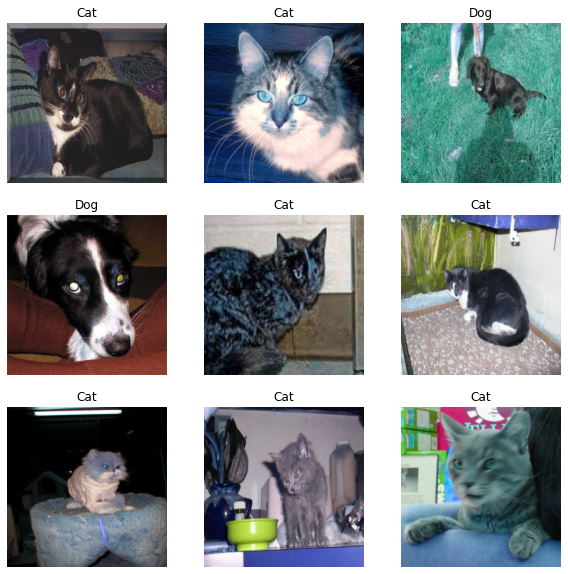

In [14]:
#Exibindo algumas amostras
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(10, 10))


for i in range(9):
        ax = plt.subplot(3, 3, i + 1)       
        plt.imshow(X_train[i+200])
        plt.title('Dog' if int(y_train[i+200][0]) else 'Cat')
        plt.axis("off")
       

In [25]:
type(X_train[0])

numpy.ndarray

In [9]:
#Uso de ImageDataGenerator para evitar problemas de overfitting.

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        zoom_range = 0.1, # Aleatory zoom
        rotation_range= 15, 
        width_shift_range=0.1,  # horizontal shift
        height_shift_range=0.1,  # vertical shift
        horizontal_flip=True,  
        vertical_flip=True)
datagen.fit(X_train)

In [14]:
#Uso de uma CNN implemetada do zero como referência

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

# build the network
model = Sequential()
print("Input dimensions: ",X_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
23/23 [==============================] - 5s 118ms/step - loss: 0.7033 - accuracy: 0.5111 - val_loss: 0.6918 - val_accuracy: 0.5458
Epoch 2/10
23/23 [==============================] - 2s 95ms/step - loss: 0.6860 - accuracy: 0.5451 - val_loss: 0.6746 - val_accuracy: 0.5729
Epoch 3/10
23/23 [==============================] - 2s 95ms/step - loss: 0.6686 - accuracy: 0.5688 - val_loss: 0.6637 - val_accuracy: 0.5938
Epoch 4/10
23/23 [==============================] - 2s 95ms/step - loss: 0.6495 - accuracy: 0.6090 - val_loss: 0.6675 - val_accuracy: 0.5771
Epoch 5/10
23/23 [==============================] - 2s 95ms/step - loss: 0.6341 - accuracy: 0.6014 - val_loss: 0.6547 - val_accuracy: 0.5958
Epoch 6/10
23/23 [==============================] - 2s 95ms/step - loss: 0.6264 - accuracy: 0.6319 - val_loss: 0.6533 - val_accuracy: 0.5979
Epoch 7/10
23/23 [==============================] - 2s 95ms/step - loss: 0.6032 - accuracy: 0.6562 - val_loss: 0.6214 - val_accuracy: 0.6438
Epoch 8/10
2

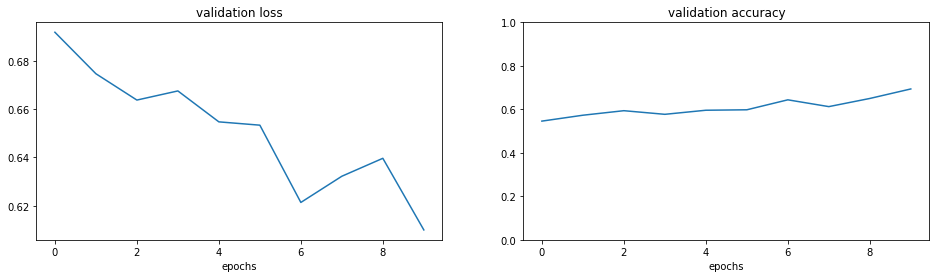

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [17]:
#A acurácia de treinamento está ficou em 0.7 enquanto, no teste próxima de 0.64.

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6251365542411804
Test accuracy: 0.6458333134651184


# Iniciando o Transfer learning

##### Como sugerido foi utilizado o modelo da VGG-16, com pesos treinados na ImageNet composto por mais de 14 milhões de imagens classificadas em mais de 20000 classes. Sendo um conjunto maior que o dataset de cães e gatos.



In [18]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [20]:
inp = vgg.input

# cria uma nova camada softmax com 2 neurônios 
new_classification_layer = Dense(2, activation='softmax')

# conecta a nova camada à penúltima camada no VGG
out = new_classification_layer(vgg.layers[-2].output)

model_new = Model(inp, out)

In [21]:
# Torna totas as camadas exceto a última não treinaveis congelando os pesos
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garante que a última camada seja treinável/não congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
history2 = model_new.fit(X_train, y_train, 
                         batch_size=64, 
                         epochs=10, 
                         validation_data=(X_val, y_val))

Epoch 1/10
23/23 [==============================] - 19s 583ms/step - loss: 0.7494 - accuracy: 0.6062 - val_loss: 0.5266 - val_accuracy: 0.7458
Epoch 2/10
23/23 [==============================] - 10s 457ms/step - loss: 0.4700 - accuracy: 0.8000 - val_loss: 0.4108 - val_accuracy: 0.8458
Epoch 3/10
23/23 [==============================] - 10s 462ms/step - loss: 0.4154 - accuracy: 0.8160 - val_loss: 0.4066 - val_accuracy: 0.7854
Epoch 4/10
23/23 [==============================] - 10s 457ms/step - loss: 0.3575 - accuracy: 0.8444 - val_loss: 0.3415 - val_accuracy: 0.8375
Epoch 5/10
23/23 [==============================] - 10s 448ms/step - loss: 0.3295 - accuracy: 0.8646 - val_loss: 0.3359 - val_accuracy: 0.8562
Epoch 6/10
23/23 [==============================] - 10s 438ms/step - loss: 0.3079 - accuracy: 0.8840 - val_loss: 0.3025 - val_accuracy: 0.8667
Epoch 7/10
23/23 [==============================] - 10s 437ms/step - loss: 0.2909 - accuracy: 0.8806 - val_loss: 0.2890 - val_accuracy: 0.8875

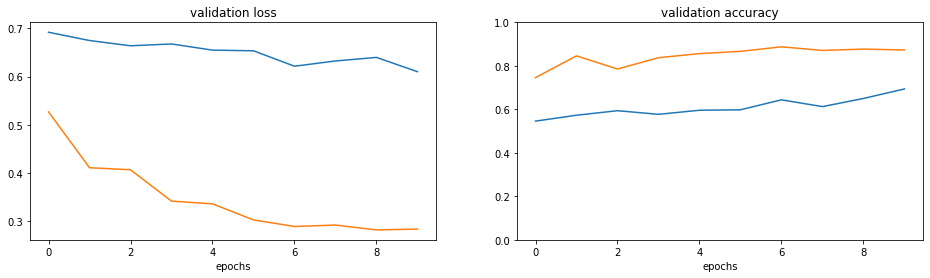

In [23]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [24]:
# A acurácia melhorou bastante 88% no conjunto de teste.

loss, accuracy = model_new.evaluate(X_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.2760615348815918
Test accuracy: 0.8854166865348816
